# Project: ANN in Genetic Algorithm for Water Distribution Systems

<h1 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; top: 60px;right: 30px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png" style="width:100px; height: auto; margin: 0"\>
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png" style="width:100px; height: auto; margin: 0"\>
</h1>
<h2 style="height: 10px">
</h2>

*[CEGM1000 MUDE](http://mude.citg.tudelft.nl/): Week 2.6. Due: Friday, Dec 22, 2023.*


This is the second part of Project 7, which takes place in Q2, Weeks 5 and 6. In these weeks, we'll apply optimization and machine learning techniques to design water distribution systems.

This notebook has three main parts. The first part is a reminder of water distribution systems and the problem framing to find the most suitable diameters with a genetic algorithm. The second part exemplifies asks you to modify the genetic algorithm developed last week to minimize the cost of the Modena Water Distribution system using the help of the artificial neural network developed in the other part of this week's project. Finally, the third part is about assessing the solutions and comparing against the solution obtained without an artificial neural network. 

Ideally, we would use the ANN all the time instead of the EPANET model. However, the ANN is not perfect and it is not always possible to use it. For example, the ANN's accuracy is not perfect. Therefore, we need to use the EPANET model to assess the solutions periodically.

Complete this assignment by the end of the session at 12:30. This means having a single notebook for your group with all code, analysis and interpretation completed. You should leave the cell outputs in the notebook.

### Working Method

We recommend that you select one group member to prepare the "master" notebooks (one for the Linear Programming part, one for this part of the project). Other group members can contribute by writing and checking code or analytic expressions on their own computer or paper and sending to the "master" computer.

**Completition requirements:**

By the end of this notebook, you should have:
- Implemented all the code cells for:
  - Defining the variables, restrictions, and objective functions in the optimization problems
  - Solving the optimization problems using PyMOO and the trained ANN.
- Answered all the questions in the notebook

## 📔 Libraries

<!-- 
# If you have not installed pytorch geometric uncomment the following lines to install it

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# !pip install wntr -->

To run this notebook you need to have installed the following packages:
- Pandas
- Numpy
- Matplotlib
- WNTR
- Scikit-learn
- PyMOO

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import wntr

# Genetic algorithm dependencies
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.core.problem import Problem

from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import IntegerRandomSampling

## ⛔ Problem definition 

The problem is to find the pipe diameters that minimize the cost of the pipe lines while satisfying the customer demand for water usage and supply pressure. 

<!-- For this application, we will only consider systems feed by reservoirs that work via gravity. -->

### 🎯 Objective function

We want to minimize the cost of the pipes. Each pipe has a different cost according to its diameter and its length. Generally, the larger the pipe, the more expensive it is. 

We can define the total cost $Z$ of installing all the pipes as the following function
$$
\begin{align}
  & min Z = \sum_{j=1}^{N}C_{j}\sum_{i=1}^{M} L_{ij}\\
\end{align}
$$ (eq_cost_function)

where $C_{j}$ is the cost of pipe per meter-length having diameter $j$.

### 🚫 Restrictions

We consider one main restriction.

1) The water should arrive at the consumer nodes with sufficient pressure. This is, there should be sufficient energy for transporting the water from the source to each of nodes. This restriction can be written as

$$
\sum_{i=1}^{N} H_{i} \leq H^{*} 
$$

<!-- \; \text{for every node i in the system.} -->

## 🧬+🤖 Exercise: Genetic algorithm with ANN metamodel

### 1. Load the metamodel

In [2]:
with open('classifier_MOD_Sklearn.p', 'rb') as handle:
    metamodel = pickle.load(handle)
with open('normalizer_MOD_Sklearn.p', 'rb') as handle:
    scaler = pickle.load(handle)

### 2. Define optimization problem

In [4]:
MM_TO_M = 0.001
cost_function_diameter_mm = {
    100: 27.7,
    125: 38.0,
    150: 40.5,
    200: 55.4,
    250: 75.0,
    300: 92.4,
    350: 123.1,
    400: 141.9,
    450: 169.3,
    500: 191.5,
    600: 246.0,
    700: 319.6,
    800: 391.1
}

pipe_index = {
    0:100,
    1:125,
    2:150,
    3:200,
    4:250,
    5:300,
    6:350,
    7:400,
    8:450,
    9:500,
    10:600,
    11:700,
    12:800,
    }

H_star = 20

def transform_index_to_diameter(matrix_indexes, pipe_index):
    return np.array([[pipe_index[j] for j in vector_indexes] for vector_indexes in matrix_indexes])

def transform_diameter_to_cost(matrix_diameters, cost_function_diameter_mm):
    return np.array([[cost_function_diameter_mm[j] for j in vector_indexes] for vector_indexes in matrix_diameters])

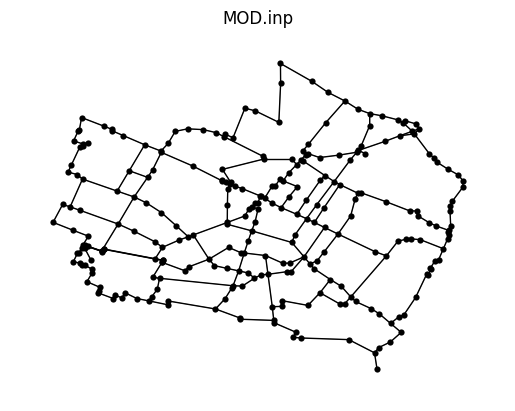

<Axes: title={'center': 'MOD.inp'}>

In [5]:
# Create a water network model
inp_file = 'MOD.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn, title=wn.name)

In [6]:
pipe_lengths = wn.query_link_attribute('length')

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Task 2.1:</b>   
    Modify the code below to define the optimization problem for the Modena Water Distribution System.
    <li> Modify the evaluation function to use the ANN metamodel instead of the EPANET model for a portion of the time. (Begin with 10% of the time.) You can do this by using the `if` statement in the evaluation function along with a random value between 0 and 1.</li>
    <li>Modify the constraint function to use a classification output (0 or 1) instead of the pressure constraints. You can do this by creating a helper variable "isSuitable" with binary values (0 or 1) and adding and having a single constraint: (-isSuitable + 0.5) (Being the 0.5 to center the constraint around 0).  </li>
    </ol>
</div>

In [32]:
num_generations = 10
population_size = 50
class ModenaOptimization(Problem):
    
    def __init__(self):
        super().__init__(n_var=317, n_obj=1, n_ieq_constr=1, xl=0.0, xu=12.0, vtype=int)

    def _evaluate(self, x, out, *args, **kwargs):
        new_population = transform_index_to_diameter(x, pipe_index)
        cost_per_unit_length = transform_diameter_to_cost(new_population, cost_function_diameter_mm)
        costs = cost_per_unit_length @ pipe_lengths


        if np.random.uniform() > 0.50:
            isSuitable = np.zeros((population_size, 1))
            # Modify the water network 
            for i, individual in enumerate(new_population):
                for j, pipe_name in enumerate(wn.pipe_name_list):
                    pipe = wn.get_link(pipe_name)
                    pipe.diameter = individual[j] * MM_TO_M
                
                #Simulate the individual
                sim = wntr.sim.EpanetSimulator(wn)
                sim_results = sim.run_sim()
                #
                
                isSuitable[i,0]= np.all(sim_results.node['pressure'].values[0][:-4] - H_star>0) #Excluding the 4 reservoirs
        else:    
            isSuitable = metamodel.predict(scaler.transform(new_population))

        
        out["F"] = costs
        out["G"] = (-isSuitable + 0.5)

problem = ModenaOptimization()
        
method = GA(pop_size=population_size,
            sampling=IntegerRandomSampling(),
            crossover=SBX(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
            mutation=PM(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
            # survival=CustomSurvival(),
            eliminate_duplicates=True,
            )

opt_results = minimize(problem,
               method,
               termination=('n_gen', num_generations),
               seed=1,
               save_history=True,
               verbose=True,
               )

print("Best solution found: %s" % opt_results.X)
print("Function value: %s" % opt_results.F)
print("Constraint violation: %s" % opt_results.CV)

n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |       50 |  0.000000E+00 |  0.1800000000 |  1.021472E+07 |  9.148062E+06
     2 |      100 |  0.000000E+00 |  0.000000E+00 |  9.799697E+06 |  7.954474E+06
     3 |      150 |  0.000000E+00 |  0.000000E+00 |  9.095296E+06 |  7.417156E+06
     4 |      200 |  0.000000E+00 |  0.000000E+00 |  8.164317E+06 |  6.251830E+06
     5 |      250 |  0.000000E+00 |  0.000000E+00 |  7.385070E+06 |  6.020445E+06
     6 |      300 |  0.000000E+00 |  0.000000E+00 |  6.937538E+06 |  5.993636E+06
     7 |      350 |  0.000000E+00 |  0.000000E+00 |  6.648501E+06 |  5.694116E+06
     8 |      400 |  0.000000E+00 |  0.000000E+00 |  6.551073E+06 |  5.694116E+06
     9 |      450 |  0.000000E+00 |  0.000000E+00 |  6.316551E+06 |  5.301520E+06
    10 |      500 |  0.000000E+00 |  0.000000E+00 |  6.291365E+06 |  5.301520E+06
Best solution found: [ 6  3  2  3  0  1  1  8  2 10  8  3  1  3  5  1  2  1  2  8  4  1  5  5  2  

Since the ANN is not perfect, some solutions will be infeasible. Therefore, we need to add a check the last population for feasible solutions.

In [33]:
final_population = opt_results.history[-1].pop.get("X")
final_population_diameters = transform_index_to_diameter(final_population, pipe_index)

In [34]:
isSuitable = np.zeros((population_size, 1))
for i, individual in enumerate(final_population_diameters):
    for j, pipe_name in enumerate(wn.pipe_name_list):
        pipe = wn.get_link(pipe_name)
        pipe.diameter = individual[j] * MM_TO_M
    
    #Simulate the individual
    sim = wntr.sim.EpanetSimulator(wn)
    sim_results = sim.run_sim()
    
    print('Min_pressure ', i, sim_results.node['pressure'].values[0][:-4].min())
    isSuitable[i,0]= np.all(sim_results.node['pressure'].values[0][:-4] - H_star>0) #Excluding the 4 reservoirs

Min_pressure  0 3.2374458
Min_pressure  1 17.176968
Min_pressure  2 15.342905
Min_pressure  3 16.892157
Min_pressure  4 9.320377
Min_pressure  5 20.16154
Min_pressure  6 12.689762
Min_pressure  7 4.0960155
Min_pressure  8 13.700001
Min_pressure  9 20.283146
Min_pressure  10 20.019928
Min_pressure  11 13.663926
Min_pressure  12 0.4737155
Min_pressure  13 14.280456
Min_pressure  14 20.432093
Min_pressure  15 3.8502748
Min_pressure  16 6.048417
Min_pressure  17 16.664467
Min_pressure  18 19.343203
Min_pressure  19 20.123045
Min_pressure  20 26.821674
Min_pressure  21 9.283869
Min_pressure  22 20.224688
Min_pressure  23 13.120146
Min_pressure  24 15.779681
Min_pressure  25 22.072739
Min_pressure  26 24.864021
Min_pressure  27 21.080267
Min_pressure  28 22.066324
Min_pressure  29 25.869688
Min_pressure  30 19.1923
Min_pressure  31 20.57588
Min_pressure  32 15.085163
Min_pressure  33 8.584083
Min_pressure  34 26.687222
Min_pressure  35 24.149069
Min_pressure  36 20.174023
Min_pressure  37 20

We can choose one solution from the last population which has a minimum pressure over 20 meters.

In [14]:
best_solution = final_population[-2]

### 2. Assess the results

In [16]:
optimal_diameters = transform_index_to_diameter([best_solution], pipe_index)[0]*MM_TO_M
print(optimal_diameters)

[0.35  0.125 0.125 0.2   0.15  0.125 0.1   0.5   0.15  0.1   0.2   0.5   0.25  0.25  0.35  0.3   0.45  0.4   0.6   0.15  0.3   0.35  0.125 0.4   0.125 0.2   0.2   0.2   0.25  0.125 0.25  0.35  0.125 0.15  0.6   0.3   0.3   0.25  0.1   0.2   0.3   0.6   0.6   0.125 0.3   0.5   0.15  0.35  0.1
 0.3   0.4   0.7   0.125 0.2   0.2   0.15  0.15  0.45  0.45  0.15  0.25  0.15  0.7   0.45  0.3   0.45  0.7   0.125 0.7   0.45  0.3   0.2   0.4   0.35  0.125 0.15  0.15  0.4   0.25  0.2   0.1   0.25  0.5   0.25  0.125 0.3   0.35  0.125 0.125 0.2   0.45  0.15  0.7   0.125 0.4   0.6   0.3   0.6
 0.4   0.2   0.1   0.45  0.35  0.2   0.2   0.25  0.4   0.45  0.15  0.125 0.1   0.2   0.4   0.3   0.25  0.125 0.7   0.3   0.15  0.25  0.6   0.6   0.4   0.15  0.15  0.45  0.125 0.1   0.3   0.25  0.45  0.7   0.1   0.1   0.5   0.1   0.125 0.4   0.2   0.4   0.3   0.125 0.25  0.1   0.15  0.2   0.6
 0.25  0.35  0.15  0.2   0.15  0.125 0.25  0.25  0.45  0.15  0.1   0.15  0.3   0.2   0.1   0.1   0.2   0.2   0.25  0.3   

In [17]:
# Modify the water network
for j, pipe_name in enumerate(wn.pipe_name_list):
    pipe = wn.get_link(pipe_name)
    # Modify the water network 
    pipe.diameter = optimal_diameters[j]
    
#Simulate the individual
# wn.options.hydraulic.demand_model = 'PDD'
sim = wntr.sim.EpanetSimulator(wn)
sim_results = sim.run_sim()

Pressure heads given by the numerical model

In [18]:
sim_results.node['pressure'].values[0][:-4].min()

22.408016

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Task 3.1:</b>   
    Interpret the results. Given the high speed of the ANN, we can save almost as much time as the percentage of time that we use it. However, we also lose accuracy and possible unfeasible solutions will appear. Quantify the trade-off between speed and accuracy. 
    <ol>
    <li> How much time does the genetic algorithm take without any help of the ANN? How much is the optimal cost found? </li> 
    <li> How much time does the genetic algorithm using the ANN 10% of the time? How much is the optimal cost found? Are the solutions feasible?</li>
    <li> How much time does the genetic algorithm using the ANN 50% of the time? How much is the optimal cost found? Are the solutions feasible?</li>
    <li> How much time does the genetic algorithm using the ANN 100% of the time? How much is the optimal cost found? Are the solutions feasible? </li>
    </ol>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Solution</b><br>
<ol> 
(These values vary between computers, initial random states, number of generations, number of individuals, etc. The values below are just an example.)
    <li> 34 seconds for 500 individuals (in 10 generations of 50 individuals). The cost is 5087089. </li>
    <li> 32 seconds for 500 individuals (in 10 generations of 50 individuals). The cost is 5766136. All feasible solutions. </li>
    <li> 9 seconds for 500 individuals (in 10 generations of 50 individuals). The cost is 5301520.17. Some solutions mixed with unfeasible solutions.</li>
    <li> 0.5 seconds for 500 individuals (in 10 generations of 50 individuals). The cost is 4098431 (Most likely with an unfeasible configuration). Mostly unfeasible unfeasible solutions. </li>
</ol>
</div>

**End of notebook.**
<h2 style="height: 60px">
</h2>
<h3 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; bottom: 60px; right: 50px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">
      <img alt="Creative Commons License" style="border-width:; width:88px; height:auto; padding-top:10px" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" />
    </a>
    <a rel="TU Delft" href="https://www.tudelft.nl/en/ceg">
      <img alt="TU Delft" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png"/>
    </a>
    <a rel="MUDE" href="http://mude.citg.tudelft.nl/">
      <img alt="MUDE" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png"/>
    </a>
    
</h3>
<span style="font-size: 75%">
&copy; Copyright 2023 <a rel="MUDE Team" href="https://studiegids.tudelft.nl/a101_displayCourse.do?course_id=65595">MUDE Teaching Team</a> TU Delft. This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.